# Medical Image Analysis<a id='Top'></a>

## Table of Contents

1. [Load Packages](#1)<br>
2. [Load Dataset](#2)<br>
3. [Display Sample Images](#3)<br>
4. [Process Data (Image)](#4)<br>
5. [Design and Develop a CNN Model](#5)<br>

## 1. Load Packages<a id=1></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

[Back to Top](#Top)

## 2. Load Dataset<a id=2></a>

I utilized a malaria dataset from the TensorFlow dataset collection. It contains images of blood smears that have been labeled to indicate whether the blood sample is infected with the malaria parasite Plasmodium or not.

This dataset consists of two classes:

* Parasitized: Images of blood smears containing red blood cells infected with the malaria parasite Plasmodium.
* Uninfected: Images of blood smears containing normal, uninfected red blood cells.

In [2]:
# Load the Malaria dataset
# https://www.tensorflow.org/datasets/catalog/malaria
dataset, info = tfds.load('malaria', split='train', as_supervised=True, with_info=True, shuffle_files=True)

# Print dataset information
print(info)

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear i

[Back to Top](#Top)

## 3. Display Sample Images<a id=3></a>

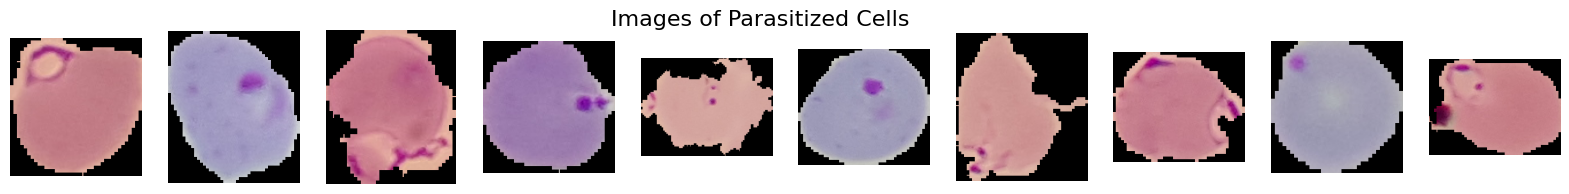

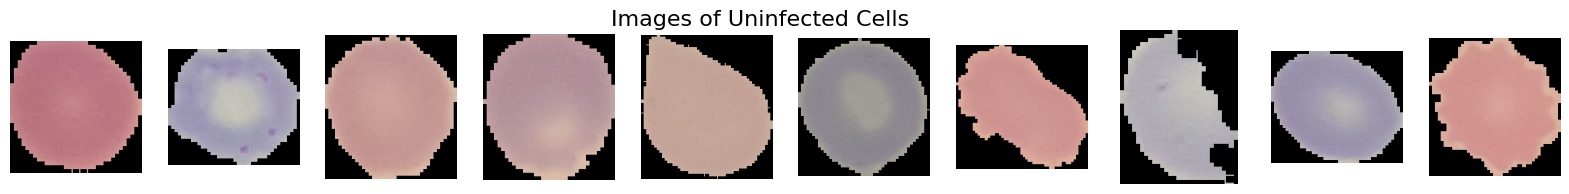

In [3]:
# Function to display images from the dataset
def show_images(dataset, label, num_images=10):
    plt.figure(figsize=(20, 2))
    plt.suptitle(f"Images of {'Parasitized Cells' if label == 0 else 'Uninfected Cells'}", fontsize=16)

    count = 0
    for img, lbl in dataset:
        if lbl.numpy() == label:
            plt.subplot(1, 10, count + 1)
            plt.imshow(img.numpy())
            plt.axis('off')
            count += 1
            if count == num_images:
                break
    plt.show()

# Display 10 images of parasitized cells (label=0)
show_images(dataset, label=0, num_images=10)

# Display 10 images of uninfected cells (label=1)
show_images(dataset, label=1, num_images=10)

[Back to Top](#Top)

## 4. Process Data (Image)<a id=4></a>

In [4]:
# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=1024, reshuffle_each_iteration=False)

# Normalize images' pixel values
dataset = dataset.map(lambda img, lbl: (tf.cast(img, tf.float32) / 255.0, lbl))

# Resize each image in the dataset
dataset = dataset.map(lambda img, lbl: (tf.image.resize(img, [64, 64], method='nearest'), lbl))

In [5]:
# Calculate the total number of examples in the dataset
num_examples = tf.data.experimental.cardinality(dataset).numpy()

# Split the dataset into training, validation, and test sets
# using 70% for training, 15% for validation, and the remaining for testing
num_train = int(0.7 * num_examples)
num_val = int(0.15 * num_examples)
num_test = num_examples - num_train - num_val

# Set the batch size
batch_size = 64

# Training dataset
train_ds = dataset.take(num_train)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Skip the 'num_train' examples to get the remaining examples
remaining_ds = dataset.skip(num_train)

# Validation dataset
val_ds = remaining_ds.take(num_val)
val_ds = val_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Test dataset
test_ds = remaining_ds.skip(num_val)
test_ds = test_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Print the number of examples in each dataset
print(f'Number of examples in the training set: {num_train}')
print(f'Number of examples in the validation set: {num_val}')
print(f'Number of examples in the test set: {num_test}')

Number of examples in the training set: 19290
Number of examples in the validation set: 4133
Number of examples in the test set: 4135


[Back to Top](#Top)

## 5. Design and Develop a CNN Model<a id=5></a>

In [6]:
# Reset Keras session
tf.keras.backend.clear_session()

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [7]:
# Pre-trained CNN model
vggModel = keras.applications.VGG16(weights='imagenet',
                                    include_top=False,
                                    input_shape=(64, 64, 3))

# Print model summary
vggModel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [8]:
# Create a new Sequential model
model = tf.keras.models.Sequential()

# Add the VGG16 model as a layer to the new model
model.add(vggModel)

model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.6))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(64,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               6

In [9]:
# Initialize earlystopping callback to mitigate overfitting
earlyStopping = keras.callbacks.EarlyStopping(monitor ='val_loss',
                                              mode ='min',
                                              patience = 10,
                                              restore_best_weights = True)
# Train the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    batch_size=batch_size,
                    epochs=25,
                    callbacks =[earlyStopping])

Epoch 1/25
302/302 [==============================] - 61s 141ms/step - loss: 0.2567 - accuracy: 0.9056 - val_loss: 0.2928 - val_accuracy: 0.9330
Epoch 2/25
302/302 [==============================] - 26s 87ms/step - loss: 0.1625 - accuracy: 0.9488 - val_loss: 0.2866 - val_accuracy: 0.8715
Epoch 3/25
302/302 [==============================] - 26s 88ms/step - loss: 0.1420 - accuracy: 0.9517 - val_loss: 0.1709 - val_accuracy: 0.9482
Epoch 4/25
302/302 [==============================] - 26s 86ms/step - loss: 0.1296 - accuracy: 0.9571 - val_loss: 0.1892 - val_accuracy: 0.9475
Epoch 5/25
302/302 [==============================] - 26s 87ms/step - loss: 0.1210 - accuracy: 0.9599 - val_loss: 0.1778 - val_accuracy: 0.9419
Epoch 6/25
302/302 [==============================] - 26s 87ms/step - loss: 0.1098 - accuracy: 0.9628 - val_loss: 0.1046 - val_accuracy: 0.9693
Epoch 7/25
302/302 [==============================] - 26s 86ms/step - loss: 0.1002 - accuracy: 0.9657 - val_loss: 0.0971 - val_accuracy

In [10]:
# Evaluate the model on the test set
loss, acc = model.evaluate(test_ds, verbose=0)

print(f'Test loss: {loss:.2f}')
print(f'Test accuracy: {acc * 100:.2f}%')

Test loss: 0.12
Test accuracy: 96.08%


[Back to Top](#Top)